# Clustering
##### Sean Wade

1. (40%) Implement the k-means clustering algorithm or the HAC (Hierarchical Agglomerative Clustering) algorithm. You will receive 10 extra credit pointes added to your final project score if you implement and answer the questions for both algorithms. Attach your source code. Use Euclidean distance for continuous attributes and (0,1) distances for nominal and unknown attributes (e.g. matching nominals have distance 0 else 1, unknown attributes have distance 1).  HAC should support both single link and complete link options.  For k-means you will pass in a specific k value for the number of clusters that should be in the resulting clustering.  Since HAC automatically generates groupings for all values of k, you will pass in a range or set of k values for which actual output will be generated. The output for the algorithm tested should include for each clustering: a) the number of clusters, b) the centroid values of each cluster, c) the number of instances tied to that centroid, d) the SSE of each cluster, and e) the total SSE of the full clustering. The sum squared error (SSE) of a single cluster is the sum of the squared distances to the cluster centroid.  Run k-means, or HAC-single link and HAC-complete link on this exact set of the sponge data set (use all columns and do not shuffle or normalize) and report your exact results for each algorithm with k=4 clusters.  For k-means use the first 4 elements of the data set as initial centroids.  This will allow us to check the accuracy of your implementation.

To help debug your implementations, you may run them on this data set (don’t shuffle or normalize it). Note that this is just the labor data set with an instance id column added for showing results.  (Do NOT use the id column or the output class column as feature data).  The results for 5-means, using the first 5 elements of the data set as initial centroids should be this.  In HAC we just do the one closest merge per iteration.  The results for HAC-single link up to 5 clusters should be this and complete link up to 5 clusters should be this.

For the sample files, we ignore missing values when calculating centroids and assign them a distance of 1 when determining total sum squared error.  Suppose you had the following instances in a cluster:

?, 1.0, Round

?, 2.0, Square

?, 3.0, Round

Red, ?, ?

Red, ?, Square

The centroid value for the first attribute would be "Red" and SSE would be 3.  The centroid value for the second attribute would be 2, and SSE would be 4.  In case of a tie as with the third attribute, we choose the nominal value which appeared first in the meta data list.  So if the attribute were declared as @attribute Shape{"Round", "Square"}, then the centroid value for the third attribute would be Round and the SSE would be 3.  For other types of ties (node or cluster with the same distance to another cluster, which should be rare), just go with the earliest cluster in your list.  If all the attributes in a cluster have don’t know for one of the attributes, then use don’t know in the centroid for that attribute.

2.   (20%) Run your variation (k-means, or HAC-single link and HAC-complete link (or both)) on the full iris data set where you do not include the output label as part of the data set. For k-means you should always choose k random points in the data set as initial centroids.  If you ever end up with any empty clusters in k-means, re-run with different initial centroids.  Run it for k = 2-7.  State whether you normalize or not (your choice).  Graph the total SSE for each k and discuss your results (i.e. what kind of clusters are being made). Now do it again where you include the output class as one of the input features and discuss your results and any differences.  For this final data set, run k-means 5 times with k=4, each time with different initial random centroids and discuss any variations in the results.

3.   (15%) Run your variation (k-means, or HAC-single link and HAC-complete link (or both)) on the following smaller (500 instance) abalone data set where you include all attributes including the normal output attribute “rings”.  Treat “rings” as a continuous variable, rather than nominal.  Why would I suggest that?  Run it for k = 2-7.  Graph your results without normalization.  Then run it again with normalization.

4. (10%) For your normalized abalone experiments, calculate and graph a performance metric for the clusterings for k = 2-7. You may use the Silhouette or some other metric including one of your own making.  If not using Silhouette, justify your metric.  Discuss how effective the metric you used might be in these cases for selecting which number of clusters is best.

5.  (15%) Do an experiment of your own regarding clustering  You only need to do one experiment even if you are implementing both algorithms for extra credit.

In [5]:
from __future__ import division
import numpy as np
from scipy.spatial import distance
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from collections import Counter

from mltools.dataManager import DataManager


from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from IPython.core.display import HTML
import urllib2
HTML(urllib2.urlopen('http://seanwade.com/jupyter_2.css').read())

In [6]:
class KMeans:
    """ My implementation of the K-means algorithms."""
    
    def __init__(self, variable_types):
        self.variable_types = variable_types
        
    def _distance(self, a, b):
        total = 0
        for i in range(len(a)):
            if self.variable_types[i] == True:
                if a[i] != b[i]:
                    total += 1
            else:
                total += np.sqrt((a[i] - b[i])**2)
        return total
    
    def _mean(self, data):
        mean = [0] * data.shape[1]
        for i in range(data.shape[1]):
            if self.variable_types[i] == True:
                mean[i] = Counter(data[:,i]).most_common(1)[0][0]
            else:
                mean[i] = np.mean(data[:,i])
        return np.array(mean)
    
    def fit(self, x_train, k=3):
        """ 
        Args:
          x_train : (np.ndarray) An NxD array array of points to cluster
          k : (int) The number of clusters
        """        
        # Init Center Guess
        n, d = x_train.shape    
        np.random.shuffle(x_train)
        k_means = x_train[:k,:]
        
        diff = [np.inf]
        while any(x > 10e-5 for x in diff):
            prev_center = k_means.copy()
            # Calc Distance from all centers
            dist_matrix = np.zeros((n, k))
            for i in range(n):
                for j in range(k):
                     dist_matrix[i][j] = self._distance(x_train[i], k_means[j])
            # Group with the closest center
            group = []
            for i in range(n):
                group.append(np.argmin(dist_matrix[i,:]))
            group = np.array(group)
            
            # Recompute centers from group
            diff = []
            for i in range(k):
                k_means[i,:] = self._mean(x_train[np.where(group==i)])
                diff.append(self._distance(k_means[i], prev_center[i]))
            
        self.k_means = k_means
        self.k = k  
        self.number_to_group = dict(Counter(group))
        
        # calc SSE
        self.sse_list = []
        for i in range(k):
            sse = 0
            group_data = x_train[np.where(group==i)]
            for j in range(group_data.shape[0]):
                sse += self._distance(k_means[i], group_data[j,:])**2
            self.sse_list.append(sse)
            
        self.full_sse = np.sum(self.sse_list)
        
                
            
    def predict(self, x_test):
        """
        Args:
          x_test : (np.ndarray) Points to classify
          
        Returns
          class : (np.ndarray) Which cluster points belong to:
        """
        n, d = x_test.shape
        dist_matrix = np.zeros((n, self.k))
        for i in range(n):
            for j in range(self.k):
                 dist_matrix[i][j] = self._distance(x_test[i], self.k_means[j])
        # Group with the closest center
        group = []
        for i in range(n):
            group.append(np.argmin(dist_matrix[i,:]))
        return np.array(group)
        

singe vs complete

- single is the min distance between clusters
- complete is the max distance

## Output
- number of clusters
- centroid values
- number of instances to each cluster
- the SSE of each cluster
- SSE of full clustering

In [15]:
data = DataManager('datasets/iris.arff')
data.normalize()

In [16]:
model = KMeans(data.is_nominal_variable()[:-1])
model.fit(data.data)
y_hat = model.predict(data.data)

In [17]:
data.labels

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,
        2.,  2.,  2.,  2.,  2.,  2.,  2.])

In [18]:
y_hat

array([0, 1, 2, 1, 1, 1, 0, 1, 2, 1, 0, 0, 0, 0, 0, 2, 1, 1, 0, 2, 0, 0, 1,
       2, 0, 2, 2, 2, 0, 0, 0, 1, 0, 1, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 2, 1,
       1, 1, 1, 2, 2, 1, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 0, 2, 2, 1, 2, 1, 2,
       0, 2, 2, 1, 1, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 2, 1, 0, 1, 2, 1, 1,
       1, 0, 0, 2, 1, 2, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 2, 2, 0, 1, 2, 1, 2,
       2, 2, 1, 1, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 1, 0, 1, 2, 1, 1, 1, 0,
       1, 0, 0, 1, 2, 1, 1, 0, 0, 2, 1, 2])

In [19]:
print accuracy_score(data.labels, y_hat)

0.346666666667


In [20]:
sse_list = []
sse_list_concat = []

for k in range(2,8):
    
    # Without label data
    model = KMeans(data.is_nominal_variable()[:-1])
    model.fit(data.data, k=k)
    y_hat = model.predict(data.data)
    
    # With label data
    concat_data = np.hstack((data.data, data.labels.reshape(150,1)))
    c_model = KMeans(data.is_nominal_variable())
    c_model.fit(concat_data, k=k)
    y_hat = c_model.predict(concat_data)
    
    sse_list.append(model.full_sse)
    sse_list_concat.append(c_model.full_sse)
    
    
print sse_list
print sse_list_concat

[620.09577614485863, 345.80437419610121, 258.06174768253749, 271.09104387208424, 192.20477079261411, 161.65441808872455]
[1026.2589029679423, 927.11648812220869, 525.1524454648345, 602.82163959118725, 414.80860930737754, 319.75674380680994]


In [21]:
for _ in range(5):
    model = KMeans(data.is_nominal_variable()[:-1])
    model.fit(data.data, k=4)
    y_hat = model.predict(data.data)
    print model.sse_list

[68.829116106567582, 29.318197048826558, 64.030509143148365, 73.927067956174696]
[68.829116106500848, 68.991694426471241, 52.681882355631778, 42.416343402835032]
[72.485450642980211, 38.086962402163358, 68.829116106488996, 49.583983525592203]
[25.502100262436159, 87.419524262310546, 9.6813359937196335, 141.57581765428225]
[70.384739325009065, 58.544815467103753, 56.846737889325865, 40.576174341912179]


## Problem 3

In [181]:
data = DataManager('datasets/abalone.arff')
data.normalize()

In [182]:
for k in range(2, 8):
    
    data = DataManager('datasets/abalone.arff')

    model = KMeans(data.is_nominal_variable()[:-1])
    model.fit(data.data, k=k)
    y_hat = model.predict(data.data)
    
    data = DataManager('datasets/abalone.arff')
    data.normalize()
    
    model = KMeans(data.is_nominal_variable()[:-1])
    model.fit(data.data, k=k)
    y_hat = model.predict(data.data)

## Problem 4

('For n_clusters =', 2, 'The average silhouette_score is :', 0.5098280748687618)


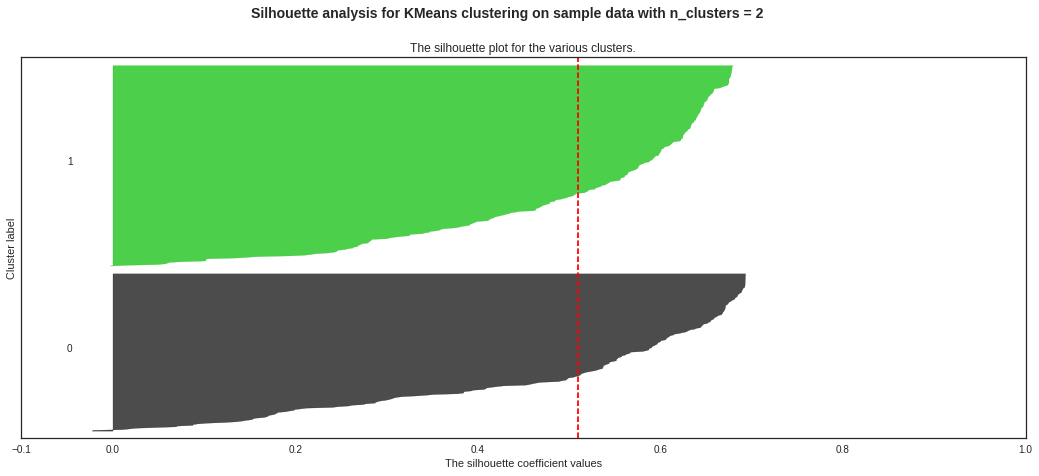

('For n_clusters =', 3, 'The average silhouette_score is :', 0.44102896462802971)


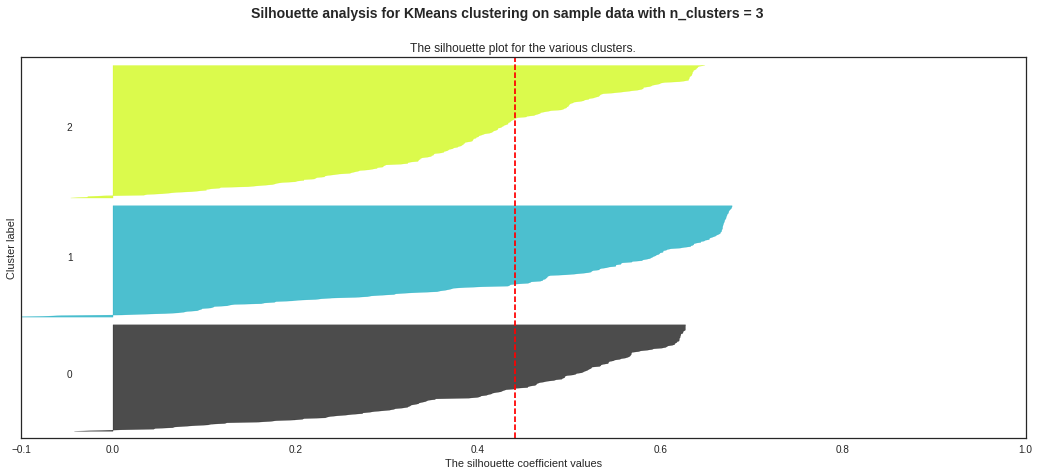

('For n_clusters =', 4, 'The average silhouette_score is :', 0.36992280739306788)


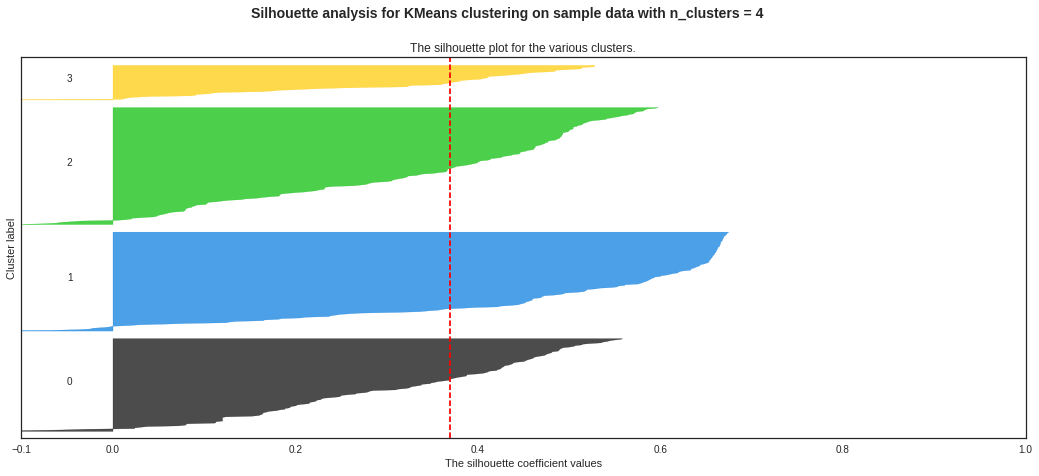

('For n_clusters =', 5, 'The average silhouette_score is :', 0.32976067305370249)


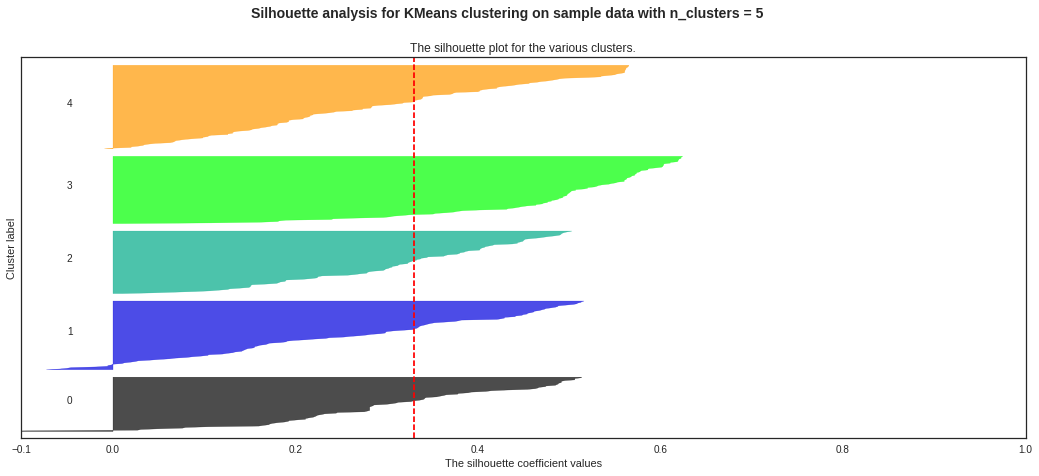

('For n_clusters =', 6, 'The average silhouette_score is :', 0.31899306424709484)


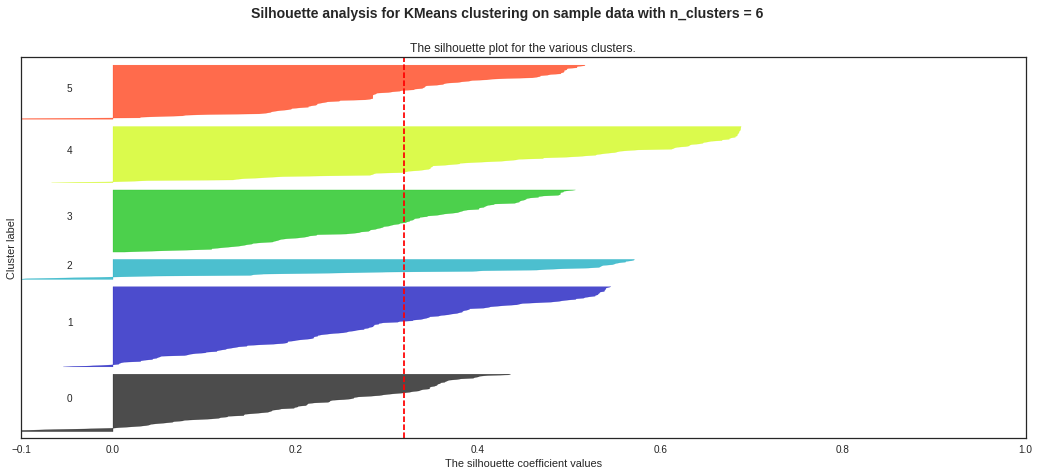

('For n_clusters =', 7, 'The average silhouette_score is :', 0.26591913382234472)


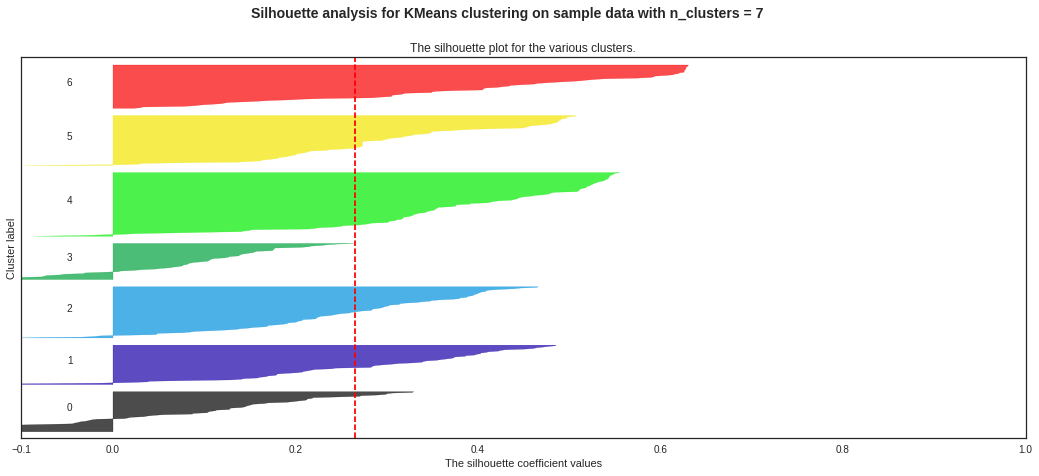

In [194]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6]

X = data.data

for n_clusters in range(2, 8):
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([0, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(data.is_nominal_variable()[:-1])
    clusterer.fit(X, k=n_clusters)
    cluster_labels =clusterer.predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data.data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])


    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()

## Create Data

For demonstration we will create a synthetic dataset that is 300 points drawn from 3 different distributions.  The goal of kmeans is to find the center of each.

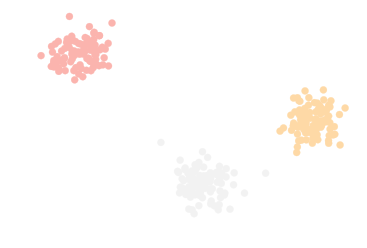

In [23]:
data, group = make_blobs(300)
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.axis('off')
plt.show()

## Plot Results

In [24]:
model = KMeans([False, False])
model.fit(data, 3)

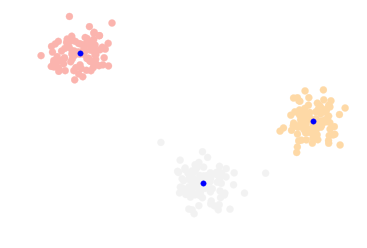

In [25]:
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.scatter(model.k_means[:,0], model.k_means[:,1], c='b', s=30)
plt.axis('off')
plt.show()

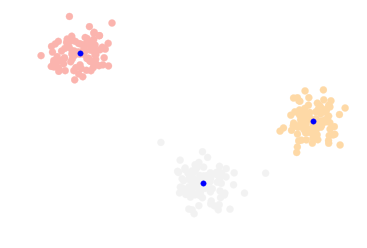

In [26]:
plt.scatter(data[:,0], data[:,1], c=group, cmap=plt.cm.Pastel1)
plt.scatter(model.k_means[:,0], model.k_means[:,1], c='b', s=30)
plt.axis('off')
plt.show()

### Plot the Decision Boundary

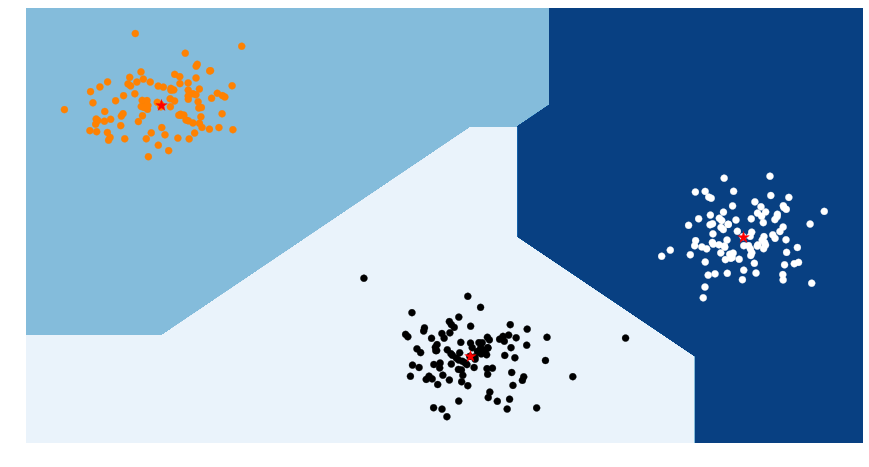

In [27]:
plt.figure(figsize=(15,8))
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02), np.arange(y_min, y_max, .02))
labels = model.predict(data)
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.Blues)

# Plot also the training points
plt.scatter(data[:,0], data[:,1], c=labels, cmap=plt.cm.afmhot)
plt.scatter(model.k_means[:,0], model.k_means[:,1], marker='*', c='r', s=150)
plt.axis('off')
plt.show()